# NLP Preprocess

### Load Cleansed Wine Reviews

See [data preparation](wine_review-data_preparation.ipynb) for details on the prepared dataset.

Libraries

In [53]:
import pandas as pd
import numpy as np

from IPython.display import Markdown, display

import matplotlib.pyplot as plt

In [54]:
wine_df = pd.read_parquet('files/wine_review.parquet.gzip')
wine_df.info()
wine_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 100538 entries, 0 to 129970
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   country         100538 non-null  object 
 1   description     100538 non-null  object 
 2   points          100538 non-null  int64  
 3   price           93522 non-null   float64
 4   taster_name     100538 non-null  object 
 5   title           100538 non-null  object 
 6   variety         100538 non-null  object 
 7   winery          100538 non-null  object 
 8   year            100538 non-null  int64  
 9   wine_style      100538 non-null  object 
 10  type            100538 non-null  object 
 11  quality         100538 non-null  object 
 12  classification  100538 non-null  object 
 13  location        100538 non-null  object 
 14  band            93522 non-null   object 
dtypes: float64(1), int64(2), object(12)
memory usage: 12.3+ MB


,country,description,points,price,taster_name,title,variety,winery,year,wine_style,type,quality,classification,location,band
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013,light_white,white,medium,Old World,Etna,None
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011,medium_red,red,medium,Old World,Douro,popular
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013,light_white,white,medium,New World,Oregon,popular
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013,aromatic_white,white,medium,New World,Michigan,popular
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012,light_red,red,medium,New World,Oregon,luxury


**Load NLP toolkit**

In [55]:
import nltk

nltk.download('all');

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/patrick/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/patrick/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/patrick/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /Users/patrick/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/patrick/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]  

**Pick a review**

In [56]:
# pick a review at random
review = next(wine_df[['title','description']].sample(1, random_state=925).itertuples())
print(review.title)
display(Markdown(review.description))


VJB 2005 Syrah (El Dorado County)


Too sweet and Porty. This mountain-grown Syrah has rich cherry-berry flavors and smooth tannins, but seems to have some residual sugar that makes it taste more like a dessert wine than a table wine.

**Helper function to create a word cloud from the description**

In [57]:
import wordcloud as wc

# Function for display frquency of words
def freq_words(words, title=''):
  '''
  Show frequency of words as an image
  '''
  # Generate frequency of words as an image
  freq_words_img = wc.WordCloud(background_color='white', random_state=2).generate(words)
  print(freq_words_img.words_)

  # Display the image
  plt.figure(figsize=(10, 10))
  plt.title(title)
  plt.imshow(freq_words_img)
  plt.axis("off")
  plt.show()

{'wine': 1.0, 'sweet': 0.5, 'Porty': 0.5, 'mountain': 0.5, 'grown': 0.5, 'Syrah': 0.5, 'rich': 0.5, 'cherry': 0.5, 'berry': 0.5, 'flavors': 0.5, 'smooth': 0.5, 'tannins': 0.5, 'seems': 0.5, 'residual': 0.5, 'sugar': 0.5, 'makes': 0.5, 'taste': 0.5, 'dessert': 0.5, 'table': 0.5}


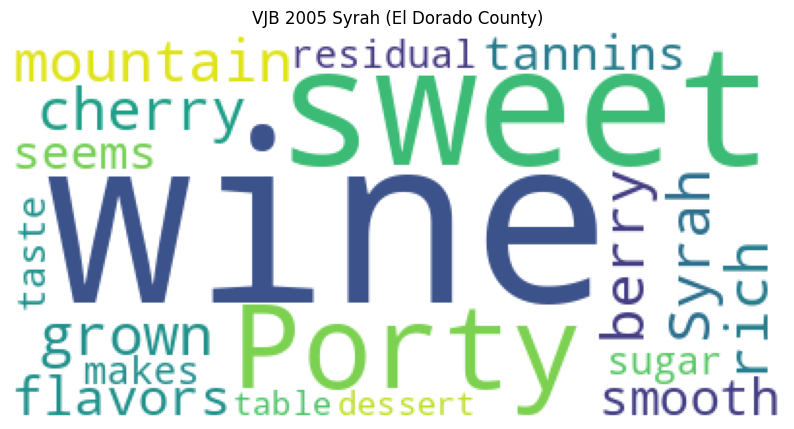

In [58]:
# create a word cloud from the description
freq_words(review.description, review.title)

### NLP Workflow
1. Split train/test data
1. Preprocess
    - Tokenization: `text -> tokens`
    - Normalization (improve quality of tokens): `tokens -> tokens`
      - Lower casing
      - converting numbers into words, or removing
      - removing punctuation and other special characters
      - removing white space
      - expanding abbreviations
      - Stop words removal, sparse terms and particular words
      - canonicalizing the text
          - part of speech
          - named entities
          - Stemming
          - Lemmatization
1. Feature ExtractionL `tokens -> numbers (vectors)`
    - Bag-of-words model
    - TF-IDF

### Tokenize

In [59]:
from nltk import word_tokenize, sent_tokenize

# split description into word tokens
tokens = word_tokenize(review.description)
print(len(tokens))
tokens[:5]

37


['Too', 'sweet', 'and', 'Porty', '.']

In [60]:
# lexical diversity: ratio of unique words to the total words
len(set(tokens))/len(tokens)

0.8918918918918919

### Normalize

**Parts of Speech**

In [61]:
token_pos = nltk.pos_tag(nltk.word_tokenize(review.description))
token_pos[:8]

[('Too', 'NNP'),
 ('sweet', 'JJ'),
 ('and', 'CC'),
 ('Porty', 'NNP'),
 ('.', '.'),
 ('This', 'DT'),
 ('mountain-grown', 'JJ'),
 ('Syrah', 'NNP')]

In [62]:
nltk.help.upenn_tagset('NNP$')

NNP: noun, proper, singular
    Motown Venneboerger Czestochwa Ranzer Conchita Trumplane Christos
    Oceanside Escobar Kreisler Sawyer Cougar Yvette Ervin ODI Darryl CTCA
    Shannon A.K.C. Meltex Liverpool ...


**Named Entity Recognition**


In [63]:
named_entities = []
for t in nltk.ne_chunk(token_pos):
    if hasattr(t,'label'):
        e_name = ' '.join(c[0] for c in t.leaves());
        e_type = t.label()
        named_entities.append((e_name, e_type))
        
print(named_entities)

[('Porty', 'GPE'), ('Syrah', 'PERSON')]


In [64]:
def keep_token(token):
  [ne]

**Remove named entities and lower case**

In [65]:
# copy the tokens
tokens_nonames = tokens.copy()

# remove any tokens that are PERSON names
for ne in named_entities:
    if ne[1]=='PERSON':
        for name in nltk.word_tokenize(ne[0]):
            tokens_nonames.remove(name)

tokens_nonames_lower = [token.lower() for token in tokens_nonames]
print(len(tokens_nonames_lower))
tokens_nonames_lower[:8]

36


['too', 'sweet', 'and', 'porty', '.', 'this', 'mountain-grown', 'has']

**Remove stopwords**

In [66]:
from nltk.corpus import stopwords
swords = stopwords.words('english') 

tokens_nonames_lower_nostop = [w for w in tokens_nonames_lower if not w in swords]
print(len(tokens_nonames_lower_nostop))
tokens_nonames_lower_nostop[:8]

21


['sweet',
 'porty',
 '.',
 'mountain-grown',
 'rich',
 'cherry-berry',
 'flavors',
 'smooth']

**Stemming**

In [67]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

# stem - convert each word token to word root form
tokens_nonames_lower_nostop_stem = [stemmer.stem(w) for w in tokens_nonames_lower_nostop]
print(len(tokens_nonames_lower_nostop_stem))
tokens_nonames_lower_nostop_stem[:8]

21


['sweet',
 'porti',
 '.',
 'mountain-grown',
 'rich',
 'cherry-berri',
 'flavor',
 'smooth']

**Lemmatization**

In [68]:
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()

tokens_nonames_lower_nostop_lemma = [stemmer.stem(w) for w in tokens_nonames_lower_nostop]
print(len(tokens_nonames_lower_nostop_lemma))
tokens_nonames_lower_nostop_lemma[:8]

21


['sweet',
 'porti',
 '.',
 'mountain-grown',
 'rich',
 'cherry-berri',
 'flavor',
 'smooth']

**Putting it all together**

In [69]:
import string
 

def clean_review(description) -> list[str]:
    # tokenize: convert text to tokens
    tokens = word_tokenize(description)
    
    #
    # normalization
    #

    # part-of-speech tagging
    token_pos = nltk.pos_tag(tokens)

    # named entity recognition
    named_entities = []
    for t in nltk.ne_chunk(token_pos):
        if hasattr(t,'label'):
            e_name = ' '.join(c[0] for c in t.leaves());
            e_type = t.label()
            named_entities.append((e_name, e_type))
    
    # remove named entities
    for ne in named_entities:
      if ne[1]=='PERSON':
          for name in nltk.word_tokenize(ne[0]):
              tokens.remove(name)
    
    # stemming transform
    stemmer = PorterStemmer()
    # lemma = WordNetLemmatizer()
    swords = stopwords.words('english') 
    return ' '.join(list(map(stemmer.stem,map(
                # convert to lower case
                lambda word: word.lower(),
                filter(
                    # remove punctuation
                    lambda word: word not in string.punctuation,
                    # remove stop words
                    filter(lambda word: word not in swords, tokens)
                  )
              ))))


In [70]:
clean_tokens = clean_review(review.description)
print(len(clean_tokens))
clean_tokens


129


'too sweet porti thi mountain-grown rich cherry-berri flavor smooth tannin seem residu sugar make tast like dessert wine tabl wine'

### Select subset of reviews

Processing the entire corpus takes time. Use a smaller subset to work our the mechanics before training on complete set.

**Determine top 3 varietals**

In [71]:
top_varieties = wine_df.variety.value_counts().sort_values(ascending=False).index.to_list()[:3]
top_varieties

['Pinot Noir', 'Chardonnay', 'Cabernet Sauvignon']

**Select a small subset of wines from the top 3 varieties**

In [72]:
n = 1000
wine_df_subset = wine_df.query('variety in @top_varieties').sample(n, random_state=42).copy()
wine_df_subset

,country,description,points,price,taster_name,title,variety,winery,year,wine_style,type,quality,classification,location,band
32797,US,"Perfumed in rose and violet, with a sauvage sc...",90,30.0,Virginie Boone,Row Eleven 2013 Dutton Sanchietti Pinot Noir (...,Pinot Noir,Row Eleven,2013,light_red,red,high,New World,California,super
105190,US,"This is a very lush Cab, made in the modern st...",92,70.0,Unknown,Robert Craig 2004 Cabernet Sauvignon (Mount Ve...,Cabernet Sauvignon,Robert Craig,2004,full_red,red,high,New World,California,luxury
89652,Australia,"Full-bodied and plush in texture, this offers ...",85,8.0,Joe Czerwinski,Yellow Tail 2015 Chardonnay (South Eastern Aus...,Chardonnay,Yellow Tail,2015,full_white,white,medium,New World,South Eastern Australia,value
115814,US,Where else in this country can you find $12 Pi...,87,12.0,Paul Gregutt,Eola Hills 2006 Pinot Noir (Oregon),Pinot Noir,Eola Hills,2006,light_red,red,medium,New World,Oregon,value
93320,US,This shows an old-fashioned Spring Mountain dr...,87,55.0,Unknown,Bougetz 2010 Amaryllis Cabernet Sauvignon (Spr...,Cabernet Sauvignon,Bougetz,2010,full_red,red,medium,New World,California,luxury
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67680,US,"This wine offers aromas of herbs, black cherry...",85,11.0,Sean P. Sullivan,Castle Rock 2012 Cabernet Sauvignon (Columbia ...,Cabernet Sauvignon,Castle Rock,2012,full_red,red,medium,New World,Washington,value
115072,US,"This wine is at the fringes in Washington, exp...",91,38.0,Sean P. Sullivan,Tulpen 2010 Dry Land Cabernet Sauvignon (Walla...,Cabernet Sauvignon,Tulpen,2010,full_red,red,high,New World,Washington,ultra
53245,France,"Based in the Côte des Blancs, Nicolas Feuillat...",90,56.0,Roger Voss,Nicolas Feuillatte 2006 Blanc de Blancs Brut C...,Chardonnay,Nicolas Feuillatte,2006,full_white,white,high,Old World,Champagne,luxury
50820,US,Not as rich or concentrated as the previous vi...,85,25.0,Unknown,Carpe Diem 2001 Firepeak Vineyard Chardonnay (...,Chardonnay,Carpe Diem,2001,full_white,white,medium,New World,California,super


**Inspect the distribution of varieties and quality features in the subset**

In [73]:
# count of reviews by variety
wine_df_subset.variety.value_counts().to_frame()

,count
variety,
Pinot Noir,393
Chardonnay,357
Cabernet Sauvignon,250


In [74]:
# count of reviews by quality
wine_df_subset.quality.value_counts().to_frame()

,count
quality,
medium,521
high,479


In [75]:
# count of reviews by points
wine_df_subset.points.value_counts().to_frame()

,count
points,
90,123
92,107
88,105
91,93
87,92
86,82
93,74
89,72
85,68


**Convert `description` to word `tokens`**

In [76]:
import swifter

wine_df_subset['tokens'] = wine_df_subset.description.swifter.apply(clean_review)
wine_df_subset.head()

Pandas Apply:   0%|          | 0/1000 [00:00<?, ?it/s]

,country,description,points,price,taster_name,title,variety,winery,year,wine_style,type,quality,classification,location,band,tokens
32797,US,"Perfumed in rose and violet, with a sauvage sc...",90,30.0,Virginie Boone,Row Eleven 2013 Dutton Sanchietti Pinot Noir (...,Pinot Noir,Row Eleven,2013,light_red,red,high,New World,California,super,perfum rose violet sauvag scent musk distinct ...
105190,US,"This is a very lush Cab, made in the modern st...",92,70.0,Unknown,Robert Craig 2004 Cabernet Sauvignon (Mount Ve...,Cabernet Sauvignon,Robert Craig,2004,full_red,red,high,New World,California,luxury,thi lush cab made modern style all element cul...
89652,Australia,"Full-bodied and plush in texture, this offers ...",85,8.0,Joe Czerwinski,Yellow Tail 2015 Chardonnay (South Eastern Aus...,Chardonnay,Yellow Tail,2015,full_white,white,medium,New World,South Eastern Australia,value,full-bodi plush textur offer plenti apricot ma...
115814,US,Where else in this country can you find $12 Pi...,87,12.0,Paul Gregutt,Eola Hills 2006 Pinot Noir (Oregon),Pinot Noir,Eola Hills,2006,light_red,red,medium,New World,Oregon,value,where els countri find 12 pinot actual variet ...
93320,US,This shows an old-fashioned Spring Mountain dr...,87,55.0,Unknown,Bougetz 2010 Amaryllis Cabernet Sauvignon (Spr...,Cabernet Sauvignon,Bougetz,2010,full_red,red,medium,New World,California,luxury,thi show old-fashion spring mountain dryness t...


In [77]:
wine_df_subset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 32797 to 11496
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         1000 non-null   object 
 1   description     1000 non-null   object 
 2   points          1000 non-null   int64  
 3   price           964 non-null    float64
 4   taster_name     1000 non-null   object 
 5   title           1000 non-null   object 
 6   variety         1000 non-null   object 
 7   winery          1000 non-null   object 
 8   year            1000 non-null   int64  
 9   wine_style      1000 non-null   object 
 10  type            1000 non-null   object 
 11  quality         1000 non-null   object 
 12  classification  1000 non-null   object 
 13  location        1000 non-null   object 
 14  band            964 non-null    object 
 15  tokens          1000 non-null   object 
dtypes: float64(1), int64(2), object(13)
memory usage: 165.1+ KB


**Save Subset with tokens**

In [78]:
wine_df_subset.to_parquet('files/wine_review_subset.parquet.gzip',compression='gzip')

# Next
- [NLP Feature Extraction](wine_review-feature_extraction.ipynb)